In [13]:
import pandas as pd
import numpy as np
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, firwin

In [14]:
input_csv_path = 'foot_sensor.csv' 
data = pd.read_csv(input_csv_path)

result = data

print("time",data['SampleTimeFine'])

time = data['SampleTimeFine']

initial_time = time[0]
adjusted_time = time - initial_time

adjusted_time_in_seconds = adjusted_time / 1e6

print("\nAdjusted time (in seconds):")
print(adjusted_time_in_seconds)

data['SampleTimeFine'] = adjusted_time_in_seconds

time 0       2848878347
1       2848886680
2       2848895013
3       2848903346
4       2848911679
           ...    
1762    2863561093
1763    2863569426
1764    2863577759
1765    2863586092
1766    2863594425
Name: SampleTimeFine, Length: 1767, dtype: int64

Adjusted time (in seconds):
0        0.000000
1        0.008333
2        0.016666
3        0.024999
4        0.033332
          ...    
1762    14.682746
1763    14.691079
1764    14.699412
1765    14.707745
1766    14.716078
Name: SampleTimeFine, Length: 1767, dtype: float64


In [15]:
# Function to convert Euler angles to a rotation matrix
def euler_to_rotation_matrix(roll, pitch, yaw):
    roll = np.deg2rad(roll)
    pitch = np.deg2rad(pitch)
    yaw = np.deg2rad(yaw)

    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    
    R_y = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    
    R_z = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    
    R = R_z @ R_y @ R_x
    return R


In [16]:
def zero_velocity_update_single_axis(acc_data, gyro_data, acc_threshold, gyro_threshold, window_size):
    stationary = np.zeros(len(acc_data), dtype=int)
    for i in range(window_size, len(acc_data) - window_size):
        acc_window = acc_data[i-window_size:i+window_size]
        acc_mean = np.mean(acc_window, axis=0)
        if abs(acc_mean) > acc_threshold:
            gyro_window = gyro_data[i-window_size:i+window_size]
            gyro_mean = np.std(gyro_window, axis=0)
            if abs(gyro_mean) > gyro_threshold:
                stationary[i-window_size:i+window_size] = 20
    return stationary

In [17]:
def zero_velocity_update(acc_data, gyro_data, acc_threshold, gyro_threshold, window_size):
    stationary = np.zeros(len(acc_data), dtype=int)
    for i in range(window_size, len(acc_data) - window_size):
        acc_window = acc_data[i-window_size:i+window_size]
        acc_mean = np.mean(acc_window, axis=0)
        
        if np.all(np.abs(acc_mean) > acc_threshold):
            gyro_window = gyro_data[i-window_size:i+window_size]
            gyro_mean = np.std(gyro_window, axis=0)
            
            if np.all(np.abs(gyro_mean) > gyro_threshold):
                stationary[i-window_size:i+window_size] = 10
                
    return stationary

In [18]:
def fir_bandpass(lowcut, highcut, fs, numtaps=101):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    taps = firwin(numtaps, [low, high], pass_zero=False)
    return taps

def bandpass_filter(data, lowcut, highcut, fs, numtaps=101):
    taps = fir_bandpass(lowcut, highcut, fs, numtaps=numtaps)
    y = filtfilt(taps, 1.0, data)
    return y

In [19]:
from scipy.signal import firwin, filtfilt

def fir_highpass(cutoff, fs, numtaps=101):
    nyquist = 0.5 * fs
    cutoff_norm = cutoff / nyquist
    taps = firwin(numtaps, cutoff_norm, pass_zero=False)
    return taps

def highpass_filter(data, cutoff=5, fs=50, numtaps=101):
    taps = fir_highpass(cutoff, fs, numtaps=numtaps)
    y = filtfilt(taps, 1.0, data)
    return y


In [20]:
global_acc_data = []

global_acc_data_minus_gravity = []

# Define gravity vector in global coordinate system
gravity_vector = np.array([0, 0, -9.80665])

for index, row in data.iterrows():
    roll = row["Euler_X"]
    pitch = row["Euler_Y"]
    yaw = row["Euler_Z"]
    
    R = euler_to_rotation_matrix(roll, pitch, yaw)
    
    acc_device = np.array([row["Acc_X"], row["Acc_Y"], row["Acc_Z"]])

    acc_global = R @ acc_device

    acc_global_minus_gravity = acc_global - gravity_vector
    
    global_acc_data.append(acc_global)

    global_acc_data_minus_gravity.append(acc_global_minus_gravity)

# to remove the initial offset value
global_acc_data_mean_value = np.mean(global_acc_data_minus_gravity[0:100],axis=0)

# Convert results to a DataFrame
global_acc_data_minus_gravity = np.array(global_acc_data_minus_gravity)
global_acc_df = pd.DataFrame(global_acc_data, columns=["Acc_X_global_origin", "Acc_Y_global_origin", "Acc_Z_global_origin"])
global_acc_df_free = pd.DataFrame(global_acc_data_minus_gravity, columns=["Acc_X_global", "Acc_Y_global", "Acc_Z_global"])

# Combine with original data
result = pd.concat([data, global_acc_df], axis=1)
result = pd.concat([result, global_acc_df_free], axis=1)

print("global_acc_data_mean_value",global_acc_data_mean_value)
result['Acc_X_global'] = result['Acc_X_global'].apply(lambda x: x-global_acc_data_mean_value[0])
result['Acc_Y_global'] = result['Acc_Y_global'].apply(lambda x: x-global_acc_data_mean_value[1])
result['Acc_Z_global'] = result['Acc_Z_global'].apply(lambda x: x-global_acc_data_mean_value[2])

# Define thresholds and window size for ZUPT
acc_threshold = 0.3 # m/s^2, this value can be tuned
gyro_threshold = 0.2  # rad/s, this value can be tuned
window_size = 30  # number of samples, this value can be tuned


global_acc_data_mean_value [-0.1245348  -0.03550651 19.53247464]


Maximum displacement: 0.0


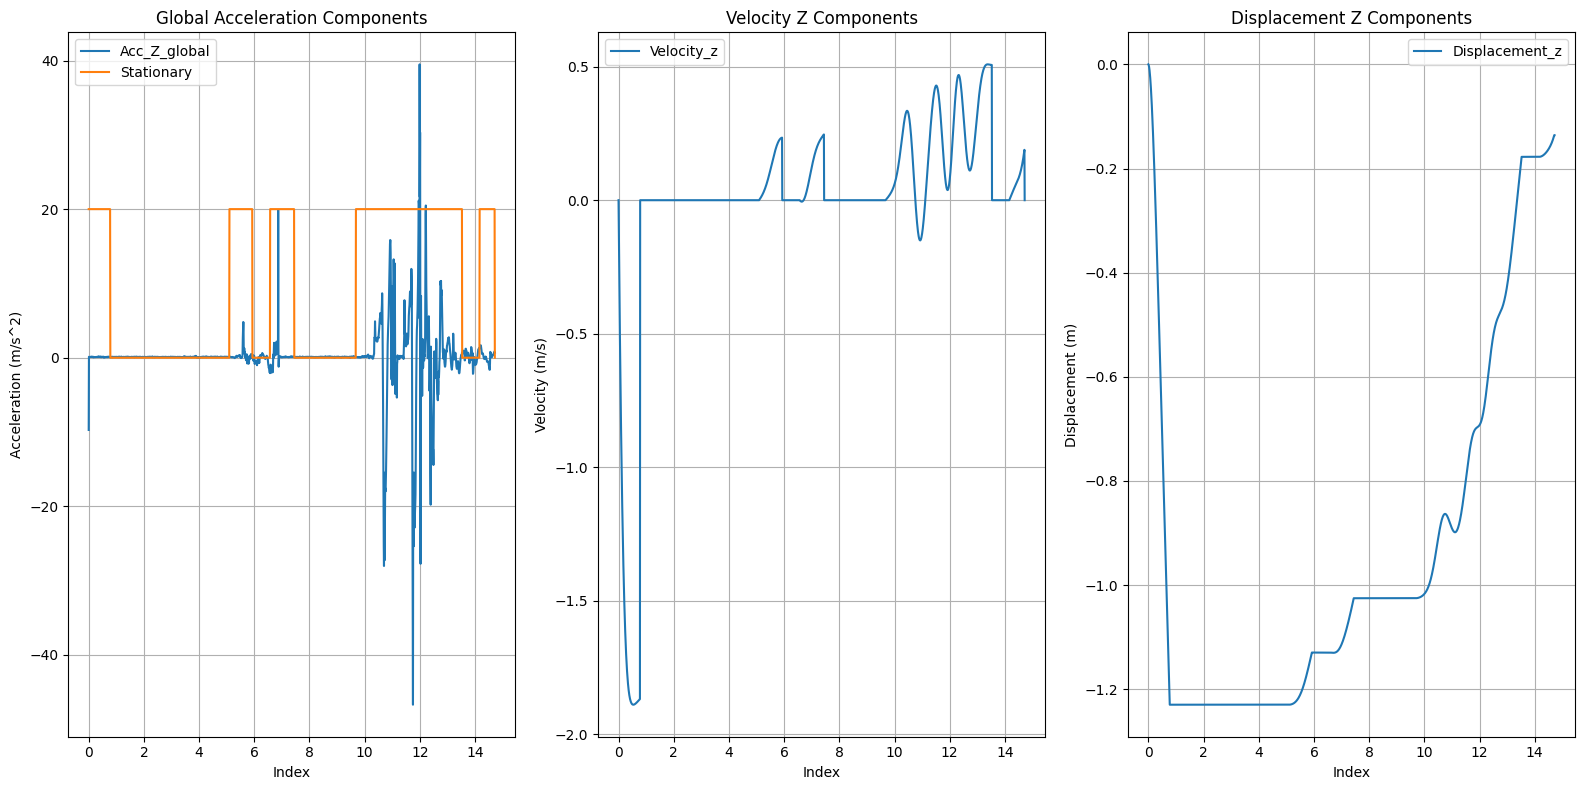

In [21]:
lowcut = 1  # Lower cutoff frequency (Hz)
highcut = 6  # Upper cutoff frequency (Hz)



result['filtered_accel_z'] = bandpass_filter(result['Acc_Z_global'],lowcut, highcut, 1000, numtaps=101)
zupt_result = zero_velocity_update_single_axis(result['filtered_accel_z'].values, result['Gyr_Z'].values, acc_threshold, gyro_threshold, window_size)

result['Stationary'] = zupt_result

velocity = np.zeros(3, dtype='float64')
displacement = np.zeros(3, dtype='float64')
velocity_z = [0]  
velocity_y = [0]  
velocity_x = [0] 
displacement_z = [0]  
displacement_y = [0] 
displacement_x = [0]  # Starting with an initial displacement of 0
drift_offset = [0]  # Drift offset for velocity calculation
velocity_x_drift_removed = [0]  # Starting with an initial velocity of 0
velocity_y_drift_removed = [0]  # Starting with an initial velocity of 0
velocity_z_drift_removed = [0]  # Starting with an initial velocity of 0

dt = 1/120  # Assuming 60 Hz sampling rate

for i in range(1, len(result)):
    
    if result.loc[i, 'Stationary']:
        # velocity_x.append(velocity_x[-1] + result['Acc_X_global'][i] * dt)
        # velocity_y.append(velocity_y[-1] + result['Acc_Y_global'][i] * dt)
        velocity_z.append(velocity_z[-1] + result['filtered_accel_z'][i] * dt)
    else:
        # velocity_x.append(0)
        # velocity_y.append(0)
        velocity_z.append(0)

    displacement_z.append(displacement_z[-1] + velocity_z[i] * dt)


result['Displacement_z'] = displacement_z
result['Velocity_z'] = velocity_z

max_displacement = result['Displacement_z'].max()
print("Maximum displacement:", max_displacement)

# # Save the results to a new CSV file
output_csv_path = 'foot_sensor_result.csv'  # Replace with your output CSV file path
result.to_csv(output_csv_path, index=False)

fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(1, 3)

# Plotting global accelerometer data
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(result['SampleTimeFine'], result['Acc_Z_global'], label='Acc_Z_global')
ax1.plot(result['SampleTimeFine'], result['Stationary'], label='Stationary')
ax1.set_xlabel('Index')
ax1.set_ylabel('Acceleration (m/s^2)')
ax1.set_title('Global Acceleration Components')
ax1.legend()
ax1.grid(True)

# Plotting velocity data
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(result['SampleTimeFine'], result['Velocity_z'], label='Velocity_z')
ax2.set_xlabel('Index')
ax2.set_ylabel('Velocity (m/s)')
ax2.set_title('Velocity Z Components')
ax2.legend()
ax2.grid(True)

# Plotting displacement data
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(result['SampleTimeFine'], result['Displacement_z'], label='Displacement_z')
ax3.set_xlabel('Index')
ax3.set_ylabel('Displacement (m)')
ax3.set_title('Displacement Z Components')
ax3.legend()
ax3.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

Maximum displacement: 0.8272145532654793


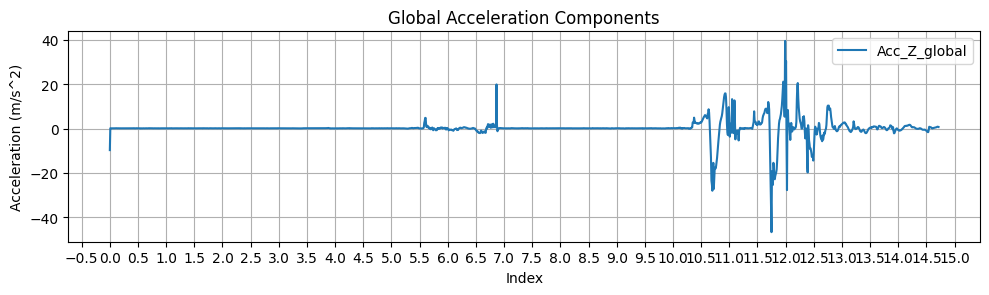

IndexError: index 1 is out of bounds for axis 1 with size 1

In [22]:

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# result['filtered_accel_z'] = highpass_filter(result['Acc_Z_global'],cutoff =1 , fs = 120)
zupt_result = zero_velocity_update_single_axis(result['Acc_Z_global'].values, result['Gyr_Z'].values, acc_threshold, gyro_threshold, window_size)

result['Stationary'] = zupt_result

velocity = np.zeros(3, dtype='float64')
displacement = np.zeros(3, dtype='float64')
velocity_z = [0]  
velocity_y = [0]  
velocity_x = [0] 
displacement_z = [0]  
displacement_y = [0] 
displacement_x = [0]  # Starting with an initial displacement of 0
drift_offset = [0]  # Drift offset for velocity calculation
velocity_x_drift_removed = [0]  # Starting with an initial velocity of 0
velocity_y_drift_removed = [0]  # Starting with an initial velocity of 0
velocity_z_drift_removed = [0]  # Starting with an initial velocity of 0

dt = 1/120  # Assuming 60 Hz sampling rate

for i in range(1, len(result)):
    
    if result.loc[i, 'Stationary']:
        # velocity_x.append(velocity_x[-1] + result['Acc_X_global'][i] * dt)
        # velocity_y.append(velocity_y[-1] + result['Acc_Y_global'][i] * dt)
        velocity_z.append(velocity_z[-1] + result['filtered_accel_z'][i] * dt)
    else:
        # velocity_x.append(0)
        # velocity_y.append(0)
        velocity_z.append(0)

    displacement_z.append(displacement_z[-1] + velocity_z[i] * dt)


result['Displacement_z'] = displacement_z
result['Velocity_z'] = velocity_z

max_displacement = result['Displacement_z'].max()
print("Maximum displacement:", max_displacement)

# # Save the results to a new CSV file
output_csv_path = 'foot_sensor_result.csv'  # Replace with your output CSV file path
result.to_csv(output_csv_path, index=False)


fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(3, 1)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(result['SampleTimeFine'], result['Acc_Z_global'], label='Acc_Z_global')
# ax1.plot(result['SampleTimeFine'], result['Stationary'], label='Stationary')
ax1.set_xlabel('Index')
ax1.set_ylabel('Acceleration (m/s^2)')
ax1.set_title('Global Acceleration Components')
ax1.legend()
ax1.grid(True)

# Adjust x-axis spacing
ax1.xaxis.set_major_locator(MultipleLocator(0.5))  # Adjust the interval to 0.5 or any other value

plt.tight_layout()
plt.show()

# Plotting velocity data
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(result['SampleTimeFine'], result['Velocity_z'], label='Velocity_z')
ax2.set_xlabel('Index')
ax2.set_ylabel('Velocity (m/s)')
ax2.set_title('Velocity Z Components')
ax2.legend()
ax2.grid(True)

# Plotting displacement data
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(result['SampleTimeFine'], result['Displacement_z'], label='Displacement_z')
ax3.set_xlabel('Index')
ax3.set_ylabel('Displacement (m)')
ax3.set_title('Displacement Z Components')
ax3.legend()
ax3.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()